- 网络架构变化
- DQN agent初始化
- 

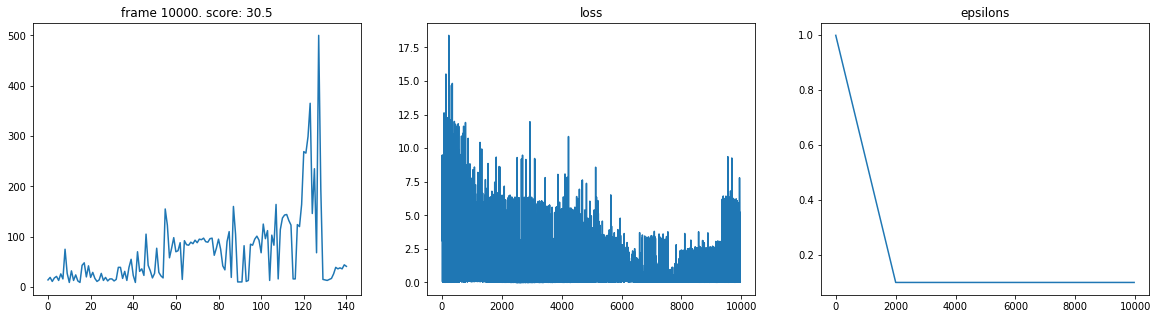

In [1]:
import os
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
import numpy as np
from typing import Dict,List,Tuple

class ReplayBuffer:
    def __init__(self,obs_dim:int,size:int,batch_size:int =32):
        self.obs_buf = np.zeros([size,obs_dim],dtype=np.float32)
        self.next_obs_buf = np.zeros([size,obs_dim],dtype = np.float32)
        self.acts_buf = np.zeros([size],dtype=np.float32)
        self.rews_buf = np.zeros([size],dtype = np.float32)
        self.done_buf = np.zeros(size,dtype = np.float32)
        self.maxsize,self.batch_size = size,batch_size
        self.ptr,self.size = 0,0
    def store(
            self,
            obs:np.ndarray,
            act:np.ndarray,
            rew:float,
            next_obs:np.ndarray,
            done:bool
    ):
        self.obs_buf[self.ptr]=obs
        self.next_obs_buf[self.ptr]=next_obs
        self.acts_buf[self.ptr]=act
        self.rews_buf[self.ptr]=rew
        self.done_buf[self.ptr]=done
        self.ptr = (self.ptr+1)%self.maxsize
        self.size = min(self.size+1,self.maxsize)
    def sample_batch(self) -> Dict[str,np.ndarray]:
        idxs = np.random.choice(self.size,self.batch_size,replace=False)
        return dict(
            obs = self.obs_buf[idxs],
            next_obs = self.next_obs_buf[idxs],
            acts = self.acts_buf[idxs],
            rews = self.rews_buf[idxs],
            done = self.done_buf[idxs]
            )
    def __len__(self) ->int:
        return self.size

class Network(nn.Module):
    def __init__(self,in_dim,out_dim,atom_size,support:torch.Tensor):
        super(Network,self).__init__()

        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        self.layers = nn.Sequential(
            nn.Linear(in_dim,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,out_dim*atom_size)
        )
    def forward(self,x:torch.Tensor) ->torch.Tensor:
            dist  = self.dist(x)
            q = torch.sum(dist*self.support,dim=2) #求均值，dist是概率分布，self.support是值，相乘后，再按照最后一维求和，得到q值，维度是[batch_size,out_dim]
            return q
    def dist(self,x:torch.Tensor) ->torch.Tensor:
        q_atoms = self.layers(x).view(-1,self.out_dim,self.atom_size) #一个批次的数据，输出维度是[batch_size,out_dim，atom_size]
        dist = F.softmax(q_atoms,dim=-1) #对最后一维进行softmax，保证每一行的和为1
        dist = dist.clamp(min=1e-3)  #将dist限制在[1e-3,1]之间
        return dist

class DQN:
    def __init__(
               self,
               env:gym.Env,
               memory_size:int,
               batch_size:int,
               target_update:int,
               epsilon_decay:float,
               seed:int,
               max_epsilon:float =1.0,
               min_epsilon:float =0.1,
               gamma:float = 0.99,

               #改进
               v_min:float = 0.0,
               v_max:float = 200.0,
               atom_size:int = 51
     ):
        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.n
        self.env = env
        self.memory = ReplayBuffer(obs_dim,memory_size,batch_size)
        self.batch_size = batch_size
        self.target_update = target_update
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.max_epsilon = max_epsilon
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        #改进
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(self.v_min,self.v_max,self.atom_size).to(self.device)

        self.dqn = Network(obs_dim,act_dim,atom_size,self.support).to(self.device)
        self.dqn_target = Network(obs_dim,act_dim,atom_size,self.support).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()                                      # target network is not trainable

        self.optimizer = optim.Adam(self.dqn.parameters(),lr = 1e-3)  #学习率需要调整
        self.transition = list()
        self.is_test = False
    
    def select_action(self,state:np.ndarray) ->np.ndarray:
         if self.epsilon > np.random.random():
             selected_action = self.env.action_space.sample()
         else:
             selected_action = self.dqn(torch.FloatTensor(state).to(self.device)).argmax() 
             #argmax()默认方法keepdim=False，因此相当于argmax(self.dqn(torch.FloatTensor(state)),dim=0,keepdim=False),返回值是零维张量
             #若 argmax(dim=0,keepdim=True)返回值是一维张量
             selected_action = selected_action.detach().cpu().numpy()    #将tensor转化为numpy,并且去掉梯度信息
         if not self.is_test:
             self.transition = [state,selected_action]          #将state和action存储起来,等待下一步的reward和next_state
         return selected_action
     
    def step(self,action:np.ndarray) -> Tuple[np.ndarray,np.float64,bool]:
        next_state,reward,terminated,truncated,_ = self.env.step(action)
        done = terminated or truncated                             #done表示是否结束,
        if not self.is_test:
            self.transition += [reward,next_state,done]            #将reward和next_state,done存储起来
            self.memory.store(*self.transition)                    #将transition存储到memory中
        return next_state,reward,done
    def update_model(self) -> torch.Tensor:
        samples = self.memory.sample_batch()
        loss = self._compute_dqn_loss(samples)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()  #.item()表示返回tensor中的元素值,不是tensor本身，不是tensor类型，所以不能反向传播
    def _compute_dqn_loss(self,samples:Dict[str,np.ndarray]) -> torch.Tensor:
        device = self.device
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        #下面设个tensor维度重构很重要，因为action,reward,done都是一维的，
        #求curr_q_value时，需要按行取值，使用gather()函数，需要保证action的维度是[batch_size,1]
        #action从行向量转化为列向量，reshape(-1,1)
        action = torch.LongTensor(samples["acts"]).to(device).reshape(-1,1)
        reward = torch.FloatTensor(samples["rews"]).to(device).reshape(-1,1)
        done = torch.FloatTensor(samples["done"]).to(device).reshape(-1,1)

        #计算Q(s_t,a_t),
        #网络的输出层维度是action数目
        #每次计算loss，都是一个批次的数据计算，在这里假设是cartpole，action数目为2，所以输出层维度为2
        #self.dqn(state).shape = [batch_size,2],action.shape = [batch_size,1],按照gather，表示取每一行的action对应的值
        #因此，curr_q_value.shape = [batch_size,1]
        curr_q_value = self.dqn(state).gather(1,action)  #gather(1,action)表示按行取action对应的值
        #计算Q(s_t+1,a_t+1)
        next_q_value = self.dqn_target(next_state).max(dim=1,keepdim=True)[0].detach() #dim=1表示按行取最大值,[0]表示取值,[1]表示取索引
        
        mask = 1-done
        target = (reward+self.gamma*next_q_value*mask).to(self.device)
        loss = F.smooth_l1_loss(curr_q_value,target)
        return loss
    def train(self,num_frames,plotting_interval=200):
        self.is_test = False
        state,_ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1,num_frames+1):
            action = self.select_action(state)
            next_state,reward,done = self.step(action)
            state = next_state
            score += reward
            if done:
                state,_ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0
            if len(self.memory) > self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                self.epsilon = max(self.min_epsilon,self.epsilon - (self.max_epsilon-self.min_epsilon)*self.epsilon_decay)
                epsilons.append(self.epsilon)

                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
            
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx,scores,losses,epsilons)
        
        self.env.close()
    
    def _target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())
    def _plot(self,frame_idx,scores,losses,epsilons):
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic =True
        torch.backends.cudnn.benchmark = False
#主函数
if __name__ == "__main__":
    env = gym.make("CartPole-v1",max_episode_steps=500,render_mode = "rgb_array")

    seed = 777
    np.random.seed(seed)
    seed_torch(seed)

    #设置参数
    num_frames = 10000
    memory_size = 1000
    batch_size = 32
    target_update = 100
    epsilon_decay = 1/2000

    agent = DQN(env=env,memory_size=memory_size,batch_size=batch_size,target_update=target_update,epsilon_decay=epsilon_decay,seed=seed)
    agent.train(num_frames)